In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torchvision.transforms as tr # 이미지 전처리 기능들을 제공하는 라이브러리
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import numpy as np # 넘파이 기본 라이브러리
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 32x32 컬러 이미지와 라벨이 각각 100장이 있다고 가정하다.
# glob -> PIL, openCV ..
# 랜덤한 정수 0 ~ 255 사이의 정수를 랜덤 선택,
# 모양은 4차원,
# /255 로 나누는 이유는, 학습시 좋아하는 포맷, 0 과 1사이의 실수를 학습시 효율적 -> 임의의 정규화와 비슷하다.
train_images = np.random.randint(256,size=(100,32,32,3))/255 # (이미지 수)x(높이)x(너비)x(채널 수)
# 랜덤한 정수 0 ~ 1 사이의 정수를 랜덤 선택
# 모양은 2차원, -> 행렬
train_labels = np.random.randint(2,size=(100,1)) # 라벨 수

In [3]:
# 전처리 기술을 직접 만들어 보자.
# 이 때 위 기본 양식과 같이 사용하기 위해 call 함수를 사용한다.
# def __call__ 내의 원하는 전처리 작업을 프로그래밍 할 수 있다.

# 1. 텐서 변환
class ToTensor:
    def __call__(self, sample):
        inputs, labels = sample
        inputs = torch.FloatTensor(inputs) # 텐서로 변환
        inputs = inputs.permute(2,0,1) # 크기 변환
        return inputs, torch.LongTensor(labels) # 텐서로 변환

# 2. 선형식
class LinearTensor:

    def __init__(self, slope=1, bias=0):
        self.slope = slope
        self.bias = bias

    def __call__(self, sample):
        inputs, labels = sample
        inputs = self.slope*inputs + self.bias # ax+b 계산하기
        return inputs, labels

# 2. CutOut
class CutOut:

    def __init__(self, ratio=.5):
        self.ratio = int(1/ratio)

    def __call__(self, sample):
        inputs, labels = sample
        active = int(np.random.randint(0, self.ratio, 1))

        if active == 0:
            _, w, h = inputs.size()
            min_len = min(w, h)
            box_size = int(min_len//4)
            idx = int(np.random.randint(0, min_len-box_size, 1))
            inputs[:,idx:idx+box_size,idx:idx+box_size] = 0

        return inputs, labels

In [4]:
# 3.3에서 사용한 양식을 그대로 사용하되 전처리 작업을 할 수 있도록 transform을 추가한다.
class MyDataset(Dataset):

    def __init__(self, x_data, y_data, transform=None):

        self.x_data = x_data # 넘파이 배열이 들어온다.
        self.y_data = y_data # 넘파이 배열이 들어온다.
        self.transform = transform
        self.len = len(y_data)
        self.tensor = ToTensor()

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample) #self.transform이 None이 아니라면 전처리를 작업한다.
        else:
            sample = self.tensor(sample)

        return sample

    def __len__(self):
        return self.len

In [5]:
#trans = tr.Compose([ToTensor(),LinearTensor(2,5)]) # 텐서 변환 후 선형식 2x+5 연산
trans = tr.Compose([ToTensor(),CutOut()])
dataset1 = MyDataset(train_images,train_labels, transform=trans)
train_loader1 = DataLoader(dataset1, batch_size=10, shuffle=True)

# ToTensor()와 tr.ToTensor()의 차이
# 앞 서 사용한 tr.ToTensor()는 import torchvision.transforms as tr를 이용한 파이토치 메소드를 이용한 것이고
# ToTensor()는 위에서 정의 된 메소드를 사용한 것이다

In [6]:
images1, labels1 = next(iter(train_loader1))
print(images1.size()) # 배치 및 이미지 크기 확인

torch.Size([10, 3, 32, 32])


C:\Users\it\AppData\Local\Temp\ipykernel_7860\1056076461.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  active = int(np.random.randint(0, self.ratio, 1))
C:\Users\it\AppData\Local\Temp\ipykernel_7860\1056076461.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = int(np.random.randint(0, min_len-box_size, 1))


In [7]:
import torchvision
def imshow(img):
    plt.figure(figsize=(10,100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

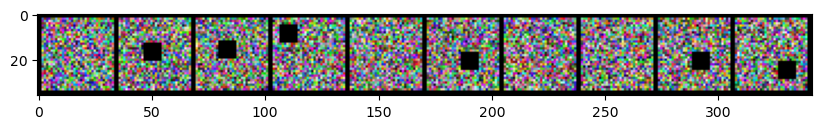

In [8]:
imshow(torchvision.utils.make_grid(images1,nrow=10))